In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
from qutip import *
import itertools as it
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'matplotlib'

# Autoencoder Attempt to Classify Product State

We will train an unsupervised neural network to reproduce a density matrix from a set of generated density matrices. The learning algorithm will attempt to minimize the trace distance between the original $\rho$ and the autoencoded $\rho$. While a large linear network could easily reproduce the density matrix, we will use a small, non-linear network in hopes that the compression will most easily handle product state than entangled states.

We begin by generating data from simulated density matrices.

In [2]:
N=3 # The number of qubits we're simulating
train_size = 5000 #The number of training examples we'll generate
test_size = 500 #The number of test examples

The following code performs a simulated complete tomography experiment on a given quantum state. The output of experiment gives us a $2^{2n}$ dimensional vector which represents the density matrix in the Pauli basis.

We'll generate data for GHZ type states, W-type states and product states to see how the network deals with them.

In [3]:
def experiment(phi,m=100,exact=True):
    #initialization
    res = []
    s = [qeye(2), sigmax(), sigmay(), sigmaz()]
    olist = []
    for i in it.product(range(4), repeat=N):
        temp = []
        for j in i:
            temp.append(s[j])
        tempop = tensor(temp)
        olist.append(tempop)
    if exact:
        res = [expect(o,phi) for o in olist]
    
    else:
        for o in olist:
            vals, vecs = o.eigenstates()
            ps = expect(ket2dm(phi),vecs)
            ps = ps
            out = np.random.choice(vals, m, p=ps)
            res.append(np.mean(out))
    
    return res 

def gen_entangled():
    phi0 = 1/np.sqrt(N)*(tensor([basis(2,0) for dummy in range(N)]) + tensor([basis(2,1) for dummy in range(N)]))
    U = tensor([rand_unitary(2) for dummy in range(N)])
    return U*phi0 

def gen_prod():
    phi0 = tensor([basis(2,0) for dummy in range(N)])
    U = tensor([rand_unitary(2) for dummy in range(N)])
    return U*phi0

def gen_w_type():
    zeros = tensor([basis(2,0) for dummy in range(N)])
    w_list = []
    for dummy in range(N):
        temp = [qeye(2) for dummy in range(N)]
        temp[dummy] = sigmax()
        temp_op=tensor(temp)
        w_list.append(temp_op)
    W = (sum(w_list)*zeros).unit()
    U = tensor([rand_unitary(2) for dummy in range(N)])
    return U*W

Now, we generate data on which to train the network. Note, the training set used here is pretty large, so the data generation can take a while.

In [308]:
prod = [experiment(gen_prod()) for dummy in range(train_size)]
product_data = np.asarray(prod)
GHZ = [experiment(gen_entangled()) for dummy in range(train_size)]
GHZ_data = np.asarray(GHZ)
w_type = [experiment(gen_w_type()) for dummy in range(train_size)]
w_data = np.asarray(w_type)

If you don't want to generate all that data, feel free to import the included data sets in the same directory.

In [25]:
with np.load('product_data.npz') as data:
    product_data = data['arr_0']
with np.load('GHZ_data.npz') as data:
    GHZ_data = data['arr_0']
with np.load('w_data.npz') as data:
    w_data = data['arr_0']

After generating or loading the data, we'll randomize the training set.

In [28]:
randomizer = np.random.permutation(3*train_size)
train_data_x = np.concatenate((product_data,w_data,GHZ_data))
np.take(train_data_x,randomizer,axis=0,out=train_data_x);

We also generate test data for testing the trained network. Again, pre-generated data is also included for ease.

In [465]:
GHZ_test = np.asarray([experiment(gen_entangled()) for dummy in range(test_size)])
product_test = np.asarray([experiment(gen_prod()) for dummy in range(test_size)])
w_test = np.asarray([experiment(gen_w_type()) for dummy in range(test_size)])

In [26]:
with np.load('product_test.npz') as data:
    product_test = data['arr_0']
with np.load('GHZ_test.npz') as data:
    GHZ_test = data['arr_0']
with np.load('w_test.npz') as data:
    w_test = data['arr_0']

If you did want to generate data, it's useful to save it. 

In [410]:
np.savez('product_data.npz',product_data)
np.savez('GHZ_data.npz',GHZ_data)
np.savez('w_data.npz',w_data)
np.savez('product_test.npz',product_test)
np.savez('GHZ_test.npz',GHZ_test)
np.savez('w_test.npz',w_test)

## Autoencoder definition and training

We define a simple, two layer autoencoder. This will encode the density matrix elements into a $n_{hidden_2}$ dimensional vector and then attempt to approximate the original state by decoding. Below, we define the model and its parameters. Much of this code was borrowed from/inspired by https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/autoencoder.py

In [265]:
# Network Parameters
n_hidden_1 = 20 # 1st layer num features
n_hidden_2 = 2 # 2nd hidden layer features
n_input = 4**N # Input data from all tomography results
batch_size = 50 # Define how many examples to feed in at once
batches = 1000 #How many batches we train on before testing

In [259]:
X = tf.placeholder(tf.float32, [None, n_input]) #Defining the placeholder for the data

We define the weights of the encoder and decoder. One approach to make the latent variables a bit easier to handle is to use a variational autoencoder(VAE). Instead of decoding the exact encoded vector like an autoencoder does, the output of the VAE encoder is a mean and standard deviation for the input. Then one makes a guess by adding a random number times the std. dev to the mean and this guessed vector is decoded. 

So far, I haven't gotten great results with this approach, so it's commented out.

In [260]:
weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'encoder_means': tf.Variable(tf.random_normal([ n_hidden_1,n_hidden_2])),
    #'encoder_logdev': tf.Variable(tf.random_normal([n_hidden_1,n_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'encoder_means': tf.Variable(tf.random_normal([n_hidden_2])),
    #'encoder_logdev': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([n_input])),
}

In [261]:
#Build the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),biases['encoder_b1']))
    means = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_means']),biases['encoder_means']))
    #logdev = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_logdev']),biases['encoder_logdev']))
    return means#, logdev

# Building the decoder
def decoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.matmul(x, weights['decoder_h1'])+ biases['decoder_b1'])
    layer_2 = tf.nn.sigmoid(tf.matmul(layer_1, weights['decoder_h2'])+ biases['decoder_b2'])
    return layer_2

In [325]:
# Construct model
enc_mean=encoder(X)#, enc_logdev = encoder(X)
#epsilon = tf.random_normal(tf.shape(enc_logdev), name='epsilon')
#std_encoder = enc_logdev#tf.exp(0.5 * enc_logdev)
sampled_enc = enc_mean #+ tf.multiply(std_encoder, epsilon) 
decoder_op = decoder(sampled_enc)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

Finally, we introduce the cost function, a squared difference (which is conveniently the trace distance) and initialize the network.

Again, commented out is the additional cost of the VAE. This cost function means the model incurs a penalty when the distribution is different from a unit Gaussian.

In [326]:
# Define loss and optimizer, minimize the trace distance
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
#latent_cost = -0.5 * tf.reduce_sum(1 + 2.0*tf.log(1e-8+enc_logdev)- tf.pow(enc_mean,2) - tf.pow(enc_logdev,2),1)
optimizer = tf.train.AdamOptimizer(.1).minimize(cost)

# Initializing the variables
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [331]:
for batch in range(batches):
    batch_xs = train_data_x[batch_size*batch:batch_size*(batch+1)].astype('float32')
    sess.run(optimizer, feed_dict={X: batch_xs})

After training, we can compute the average value of the cost function on our test data for each type.

In [328]:
print(sess.run(cost, feed_dict={X: product_test}))
print(sess.run(cost, feed_dict={X: GHZ_test}))
print(sess.run(cost, feed_dict={X: w_test}))

0.0647771
0.0429269
0.117404


We can visualize the cost for each class to see if there's any pattern.

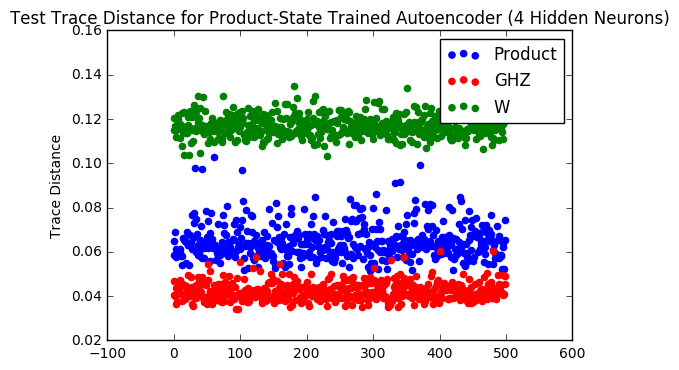

In [332]:
scatter_index = np.arange(0,test_size)

plt.scatter(scatter_index,sess.run(tf.reduce_mean(tf.pow(y_true - y_pred, 2),1),feed_dict={X: product_test}),
            color='b',label='Product')
plt.scatter(scatter_index,sess.run(tf.reduce_mean(tf.pow(y_true - y_pred, 2),1),feed_dict={X: GHZ_test}),
            color='r',label='GHZ')
plt.scatter(scatter_index,sess.run(tf.reduce_mean(tf.pow(y_true - y_pred, 2),1),feed_dict={X: w_test}),
            label='W', color='g')
plt.legend()
plt.ylabel('Trace Distance')
plt.title('Test Trace Distance for Product-State Trained Autoencoder (4 Hidden Neurons)')

Generically, my runs have not given a meaningful separation between the classes with the autoencoder. My VAE will have a large distinction with GHZ, product and then W states in terms of increasing cost.

Finally, we can consider the latent variables which are the output of the encoder. Since we've constructed a 2 neuron output, we can simply plot the encoded values of the test set. Generally, here I do see a large separation for each class, but in the VAE, the enforcing of the Gaussian shape makes them all collapse.

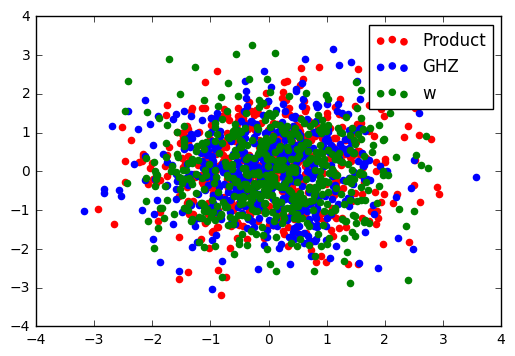

In [333]:
plt.scatter(sess.run(sampled_enc, feed_dict={X:product_test})[:,0],
            sess.run(sampled_enc, feed_dict={X:product_test})[:,1], color='r', label='Product')
plt.scatter(sess.run(sampled_enc, feed_dict={X:GHZ_test})[:,0],
            sess.run(sampled_enc, feed_dict={X:GHZ_test})[:,1], color='b', label='GHZ')
plt.scatter(sess.run(sampled_enc, feed_dict={X:w_test})[:,0],
            sess.run(sampled_enc, feed_dict={X:w_test})[:,1], color='g', label='w')
plt.legend()